# Imports

In [1]:
import boto3
import sagemaker
from sagemaker import Session
from sagemaker.session import TrainingInput
from sagemaker.tensorflow import TensorFlow as tf
from sagemaker.tensorflow import TensorFlowModel
from sagemaker.tuner import HyperparameterTuner, IntegerParameter, ContinuousParameter, CategoricalParameter
from sagemaker.serializers import JSONSerializer
from sagemaker.deserializers import JSONDeserializer
import tensorflow
import s3fs
import numpy as np
import json
import time
RANDOM_SEED = 0
sagemaker.__version__

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


2025-08-16 04:11:42.602547: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


'2.245.0'

# Sagemaker Initialization

In [20]:
fs = s3fs.S3FileSystem()
sess = sagemaker.Session()
role = sagemaker.get_execution_role()
s3 = boto3.client("s3")
bucket = sess.default_bucket()   # will be sagemaker-ap-southeast-2-838084669510
prefix = "aiornot"
print(f"S3 Bucket: f{bucket}")

s3_train_path = f"s3://{bucket}/{prefix}/train/train.npz"
s3_small_train_path = f"s3://{bucket}/{prefix}/small_train/small_train.npz"

s3_test_path = f"s3://{bucket}/{prefix}/test/test.npz"
s3_tiny_test_path = f"s3://{bucket}/{prefix}/tiny_test/tiny_test.npz"
s3_holdout_test_path = f"s3://{bucket}/{prefix}/holdout_test/holdout_test.npz"
s3_output_location = f"s3://{bucket}/{prefix}/model_output"

train_input = TrainingInput(s3_small_train_path, content_type="application/x-npz")

test_input = TrainingInput(s3_test_path, content_type="application/x-npz")

S3 Bucket: fsagemaker-ap-southeast-2-838084669510


# Transfer Learning Configuration

In [17]:
metric_definitions = [
    {"Name": "val_auc",       "Regex": "val_auc: ([0-9\\.]+)"},
    {"Name": "val_f1",        "Regex": "val_f1: ([0-9\\.]+)"},
    {"Name": "val_precision", "Regex": "val_precision: ([0-9\\.]+)"},
    {"Name": "val_recall",    "Regex": "val_recall: ([0-9\\.]+)"},
    {"Name": "val_accuracy",  "Regex": "val_accuracy: ([0-9\\.]+)"},
]

estimator = tf(
    entry_point="train_transfer.py",
    source_dir="src",
    role=role,
    instance_type="ml.c5.2xlarge",
    instance_count=1,
    framework_version="2.14",
    py_version="py310",
    output_path=f"s3://{bucket}/model_output",
    hyperparameters={
        "epochs": 3,
        "height": 224, "width": 224, "channels": 3,
        "batch-size": 1,                 # keep tiny to avoid OOM
        "learning-rate": 5e-5,           # slightly lower LR for fine-tuning
        "dropout-rate": 0.2,
        "unfreeze-fraction": 0.10,       # ← fine-tune last 10%
    },
    metric_definitions=metric_definitions,
)

job_name = f"transfer-learning-{time.strftime('%Y%m%d-%H%M%S')}"
estimator.fit({"train": train_input, "test": test_input}, job_name=job_name)

INFO:sagemaker.telemetry.telemetry_logging:SageMaker Python SDK will collect telemetry to help us better understand our user's needs, diagnose issues, and deliver additional features.
To opt out of telemetry, please disable via TelemetryOptOut parameter in SDK defaults config. For more information, refer to https://sagemaker.readthedocs.io/en/stable/overview.html#configuring-and-using-defaults-with-the-sagemaker-python-sdk.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: transfer-learning-20250816-075841


2025-08-16 07:58:43 Starting - Starting the training job...
2025-08-16 07:59:13 Downloading - Downloading input data.........
2025-08-16 08:00:44 Training - Training image download completed. Training in progress.../usr/local/lib/python3.10/site-packages/paramiko/pkey.py:100: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
/usr/local/lib/python3.10/site-packages/paramiko/transport.py:259: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,
2025-08-16 08:00:54.677078: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F, in other operations, re

In [19]:
transfer_model_s3_path = "s3://sagemaker-ap-southeast-2-838084669510/model_output/transfer-learning-20250816-075841/output/model.tar.gz"
final_tf_transfer_model = TensorFlowModel(
    model_data=transfer_model_s3_path,
    role=role,
    framework_version="2.14"
)

predictor = final_tf_transfer_model.deploy(
    initial_instance_count=1,
    instance_type="ml.m5.large",
    endpoint_name="transfer-model-endpoint"
)

INFO:sagemaker.tensorflow.model:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating model with name: tensorflow-inference-2025-08-16-08-25-51-145
INFO:sagemaker:Creating endpoint-config with name transfer-model-endpoint
INFO:sagemaker:Creating endpoint with name transfer-model-endpoint


----!

In [25]:
from sklearn.metrics import classification_report, accuracy_score
# Load test set locally (you’ll need it locally for label comparison)

# 1) load
with fs.open(s3_tiny_test_path, "rb") as f:
    d = np.load(f)
    X = d["image"].astype("float32") 
    y_true = np.asarray(d["label"], dtype=int).ravel()
    print("data loaded")

# 3) predict in micro-batches to avoid 413
def predict_batches(pred, X, bs=2):
    probs = []
    for i in range(0, len(X), bs):
        out = pred.predict(X[i:i+bs].tolist())
        p = np.array(out.get("predictions", out)).reshape(-1)  # shape (bs,)
        probs.append(p)
        print(f"{i}/{len(X)}")
    return np.concatenate(probs)

probs = predict_batches(predictor, X, bs=1)
y_pred = (probs >= 0.5).astype(int)

data loaded
0/20
1/20
2/20
3/20
4/20
5/20
6/20
7/20
8/20
9/20
10/20
11/20
12/20
13/20
14/20
15/20
16/20
17/20
18/20
19/20


In [23]:
y_true

array([1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1])

In [24]:
y_pred

array([1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0])

In [26]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
metrics = {
    "precision": precision_score(y_true, y_pred, zero_division=0),
    "recall": recall_score(y_true, y_pred, zero_division=0),
    "f1": f1_score(y_true, y_pred, zero_division=0),
    "accuracy": accuracy_score(y_true, y_pred),
}
df_metrics = pd.DataFrame([metrics]).round(4)
df_metrics

,precision,recall,f1,accuracy
0,1.0,0.8,0.8889,0.9


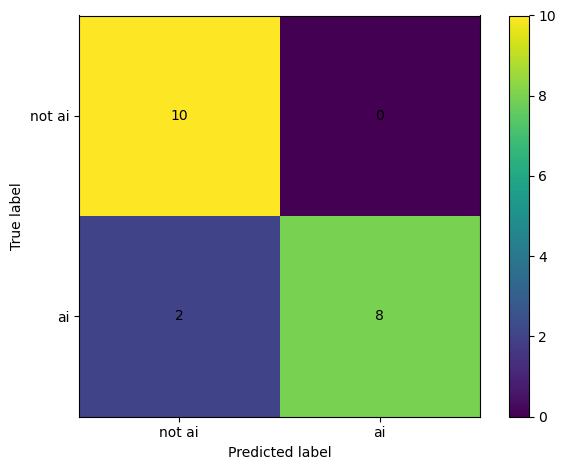

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

labels = ["not ai", "ai"] 
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation="nearest")
ax.figure.colorbar(im, ax=ax)
ax.set_xticks(np.arange(2), labels=labels)
ax.set_yticks(np.arange(2), labels=labels)
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha="center", va="center")
plt.tight_layout()
plt.show()
